In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install pdfminer.six


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 54.9 MB/s eta 0:00:00


In [5]:
pip install rapidfuzz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 36.5 MB/s eta 0:00:00


In [6]:
!pip install faiss-gpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 8.6 MB/s eta 0:00:00


In [7]:
from transformers import pipeline

In [8]:
import re
from pdfminer.high_level import extract_text
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer, util
import spacy
from rapidfuzz import fuzz, process



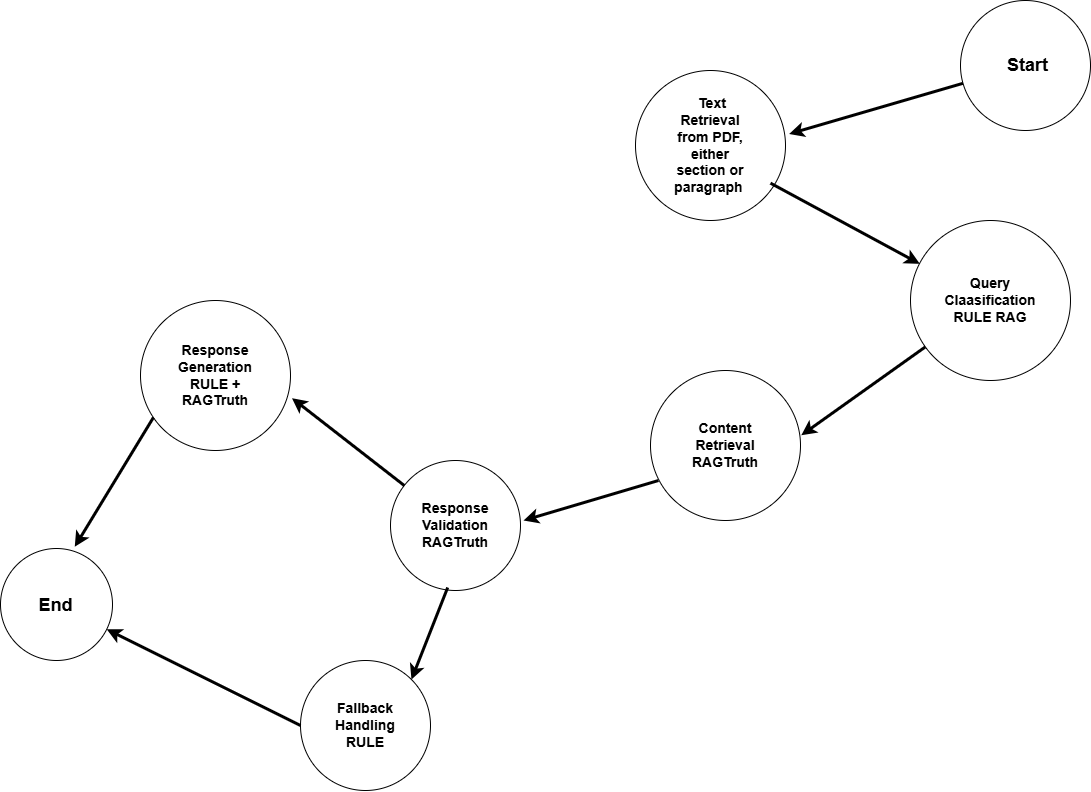










1.   Task 1: Text Retrieval and Storing


*   Extraction of text from the PDF.
*   Segementation of content into chunks, I have tried with two ways: Section and Paragraph.
*   Creating Embeddings.
*   Storing Embeddings in a vector database, here FAISS.




2.   Task 2: Query Classification (RULE RAG)



*   Defining the RULES.
*   Query Parsing.
*   Section Prioritization.

3.   Task 3: Content Retrieval (RAGTruth)


*   Semantically searching indexed knowledge base using query embeddings.
*   Rank retrieved chunks by relevance scores, in my case cosine similarity.

4.   Task 4: Response Validation (RAGTruth)


*   Validating the retrieved content using a confidence threshold.
*   If multiple sources are retrieved, cross-check for consistency.
*   Eliminating low-confidence chunks

5.   Task 5: Response Generation (RULE + RAGTruth)


*   RULE for structured generation, using templates.
*   RAGTruth to generate answers directly from validated content, I have text summarizer.

6.   Task 6: Response Validation (RULE)


*   Defining RULEs for fallback activation, using threshold information.
*   Generation of fallback messages.








Extracting the Text from PDF based in sections using pdfminer

In [9]:
def extract_text_pdfminer(pdf_path):
    text = extract_text(pdf_path)
    return text

In [10]:
title_patterns = [
    r"Message from the Vice Chancellor",
    r"Message from the Director",
    r"Defini;ions",
    r"Admissions",
    r"Academics",
    r"Examination & Evaluation",
    r"Placement Assistance",
    r"Student Support Services Guidelines",
    r"People you should know"
]

Based on the above titles, I am trying to segregate the whole content associating it with the corresponding title.

In [11]:
def segment_by_titles(text, title_patterns):

    title_regex = re.compile(rf"({'|'.join(title_patterns)})", re.IGNORECASE)
    sections = []
    current_section = {"title": None, "content": ""}

    for line in text.splitlines():
        if title_regex.match(line.strip()):
            if current_section["title"]:
                sections.append(current_section)
            current_section = {"title": line.strip(), "content": ""}
        else:
            current_section["content"] += f"{line.strip()}\n"

    if current_section["title"]:
        sections.append(current_section)

    return sections


In [12]:
pdf_path = '/content/drive/MyDrive/input.pdf'
pdf_text = extract_text_pdfminer(pdf_path)
segmented_content = segment_by_titles(pdf_text, title_patterns)

In [44]:
len(segmented_content)

7

Here "definitions" was missing. So I had to manually, find the corresponding part and hardcode it to fall into different section.

In [13]:
def break_section_by_phrase(segmented_content, section_index, phrase, new_section_title):

    updated_sections = []
    for i, section in enumerate(segmented_content):
        if i == section_index:
            if phrase in section["content"]:
                split_index = section["content"].find(phrase)

                before_phrase = section["content"][:split_index].strip()
                after_phrase = section["content"][split_index:].strip()

                if before_phrase:
                    section["content"] = before_phrase
                    updated_sections.append(section)

                new_section = {"title": new_section_title, "content": after_phrase}
                updated_sections.append(new_section)
            else:
                updated_sections.append(section)
        else:
            updated_sections.append(section)

    return updated_sections

phrase = "\n\n5\n\n\nDeﬁni;ons\n\nThe University: A dominant player in Management"
new_section_title = "Definitions"
updated_segmented_content = break_section_by_phrase(
    segmented_content, section_index=1, phrase=phrase, new_section_title=new_section_title
)



In [45]:
len(updated_segmented_content)

8

MPNet (Masked and Permuted Pre-trained Network) is a transformer-based model similar to BERT but more efficient. It improves over traditional BERT by considering dependencies among masked tokens during pre-training.

In [14]:
def generate_embeddings(chunks):

    model = SentenceTransformer('multi-qa-MPNet-base-dot-v1')
    embeddings = model.encode(chunks, convert_to_tensor=False)
    return embeddings

chunked_text = [section["content"] for section in updated_segmented_content]

embeddings = generate_embeddings(chunked_text)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.71k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Vector indexing and search using FAISS

In [15]:
def store_in_faiss(embeddings):

    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    faiss.normalize_L2(embeddings)
    index.add(embeddings)
    return index

embeddings_array = np.array(embeddings, dtype='float32')

faiss_index = store_in_faiss(embeddings_array)

In [ ]:
###############################################################################################################

RULE for Query classification

As humans, we need to set those categories ourselves based on the knowledge base, from the PDF I have empirically chosen these classes. We can add more if required.

In [16]:
RULES = {
    "Definition": ["what is", "define", "explain"],
    "Procedural": ["how to", "steps", "process", "procedure", "register", "admission"],
    "Policy": ["fee", "refund", "eligibility", "rules", "policy"],
    "Contact": ["contact", "email", "phone", "whom to contact"]
}

Note that, there is a fallback here too, but it is not a fall back in traditional sense. If the query does not fall into one of the above classes, then it should belong to general class, in this case, the whole corpus.

In [17]:
SECTION_MAPPING = {
    "Definition": ["Definitions"],
    "Procedural": ["Admission"],
    "Policy": ["Examination & Evaluation", "Academics"],
    "Contact": ["People you should know", "Student Support Services Guidelines"],
    "General": ["Message from the Vice Chancellor", "Message from the Director","People you should know","Student Support Services Guidelines", "Examination & Evaluation","Academics","Admission","Definitions"]
}

In [18]:
def classify_query_using_rules(query):

    query_lower = query.lower()
    for intent, keywords in RULES.items():
        if any(keyword in query_lower for keyword in keywords):
            return intent
    return "General"

In [19]:
def prioritize_sections(intent, updated_segmented_content):

    if intent in SECTION_MAPPING:
        matching_sections = []
        for section in updated_segmented_content:
            if section['title'] in SECTION_MAPPING[intent]:
                matching_sections.append(section)
        if matching_sections:
            return matching_sections
    return None


In [20]:
def search_with_fallback(query, faiss_index, model, updated_segmented_content, top_k=5):

    query_embedding = model.encode([query], convert_to_tensor=False)
    faiss.normalize_L2(query_embedding)

    distances, indices = faiss_index.search(np.array(query_embedding).astype('float32'), top_k)

    results = []
    for idx, distance in zip(indices[0], distances[0]):
        section = updated_segmented_content[idx]
        results.append({"title": section['title'], "content": section['content'], "distance": distance})
    return results


Here the integration means, the integration of those four rule classes and the general class. This helps in reducing the scope, if the query is classified into one of those classes. Else, the scope remains the full knowledge base.  

In [41]:
def integrated_query_handling(query, faiss_index, model, updated_segmented_content):

    intent = classify_query_using_rules(query)
    print(f"Classified Intent: {intent}")

    matching_sections = prioritize_sections(intent, updated_segmented_content)
    if matching_sections:
        print("Matched Sections Based on Rules:")
        for section in matching_sections:
            print(f"Title: {section['title']}")
            print(f"Content:\n{section['content'][:500]}")
            print("-" * 80)
    else:
        print("No exact matches found. Fallback to semantic search...")

        top_results = search_with_fallback(query, faiss_index, model, updated_segmented_content)
        print("Top Matching Sections from Semantic Search:")
        for result in top_results:
            print(f"Title: {result['title']}")
            #print(f"Content:\n{result['content'][:500]}")
            print(f"Distance: {result['distance']}")
            print("-" * 80)

In [22]:
  model = SentenceTransformer('multi-qa-MPNet-base-dot-v1')



Below example, is to illustrate what the intent is, intent is the class of the query. Here it falls under definitions



In [43]:
query = "What is the meaning of university?"
integrated_query_handling(
    query=query,
    faiss_index=faiss_index,
    model=model,
    updated_segmented_content=updated_segmented_content
)

Classified Intent: Definition
Matched Sections Based on Rules:
Title: Definitions
Content:
5


Deﬁni;ons

The University: A dominant player in Management Educa9on, research, corporate training and
consulting in the city of Mumbai since 1981, Narsee Monjee Ins9tute of Management Studies was
set up by Shri Vile Parle Kelavani Mandal in 1981 with ﬁnancial assistance from Narsee Monjee
Educa9on  Trust  hence  deriving  its  iden9ty  as  SVKM’s  NMIMS  University.  SVKM’s  NMIMS  was
declared as Deemed-to-be University under Sec9on 3 of the UGC Act, 1956. It is also a member
of AIU – Assoc
--------------------------------------------------------------------------------


RAGTruth for Content Retrieval

In [ ]:
##############################################################################################################


Now that the scope is reduced using the RULERAG, we perform global search, as we call in RAGTruth.





In [23]:
def retrieve_relevant_content(query, faiss_index, model, segmented_content, prioritized_sections=None, top_k=5, include_context=False):

    # Step 1: Restricting the search scope if prioritized sections exist
    if prioritized_sections:
        print("Using prioritized sections for retrieval.")
        content_to_search = prioritized_sections
    else:
        print("No prioritized sections found. Performing global search.")
        content_to_search = segmented_content

    chunked_text = [section["content"] for section in content_to_search]
    content_embeddings = model.encode(chunked_text, convert_to_tensor=False)

    # Creating a temporary FAISS index for the content scope
    temp_faiss_index = faiss.IndexFlatL2(content_embeddings.shape[1])
    faiss.normalize_L2(content_embeddings)
    temp_faiss_index.add(np.array(content_embeddings, dtype='float32'))

    query_embedding = model.encode([query], convert_to_tensor=False)
    faiss.normalize_L2(query_embedding)

    distances, indices = temp_faiss_index.search(np.array(query_embedding).astype('float32'), top_k)

    results = []
    for idx, distance in zip(indices[0], distances[0]):
        section = content_to_search[idx]
        result = {
            "title": section["title"],
            "content": section["content"],
            "distance": distance
        }
        results.append(result)

    if include_context:
        results_with_context = []
        for result in results:
            section_index = segmented_content.index(
                next(sec for sec in segmented_content if sec["title"] == result["title"])
            )
            context = {
                "title": result["title"],
                "content": result["content"],
                "distance": result["distance"],
                "context_before": segmented_content[section_index - 1]["content"] if section_index > 0 else "",
                "context_after": segmented_content[section_index + 1]["content"] if section_index < len(segmented_content) - 1 else ""
            }
            results_with_context.append(context)
        return results_with_context

    return results


In [24]:
def integrated_pipeline(query, faiss_index, model, segmented_content):

    # Step 1:Classification of query
    query_intent = classify_query_using_rules(query)
    prioritized_sections = prioritize_sections(query_intent, segmented_content)

    # Step 2: Content Retrieval
    results = retrieve_relevant_content(
        query=query,
        faiss_index=faiss_index,
        model=model,
        segmented_content=segmented_content,
        prioritized_sections=prioritized_sections,
        top_k=5,
        include_context=True
    )

    return results


In the example, shown below, We can clearly see the priorities. High priority imply giher confidence level and lower distance. Here distance refers to the cosine similarity.

In [25]:
# Example Query
query = "What are the fees for admission?"

results = integrated_pipeline(query, faiss_index, model, updated_segmented_content)

print("\nRetrieved Content:")
for result in results:
    print(f"Title: {result['title']}")
    #print(f"Content: {result['content'][:500]}")
    print(f"Distance: {result.get('distance', 'N/A')}")
    print("-" * 80)


No prioritized sections found. Performing global search.

Retrieved Content:
Title: Admissions
Distance: 1.080774188041687
--------------------------------------------------------------------------------
Title: Student Support Services Guidelines
Distance: 1.131744384765625
--------------------------------------------------------------------------------
Title: People you should know
Distance: 1.158896565437317
--------------------------------------------------------------------------------
Title: Academics
Distance: 1.165386438369751
--------------------------------------------------------------------------------
Title: Definitions
Distance: 1.1829224824905396
--------------------------------------------------------------------------------


Below is the code foe validation, that is just returning the class with highest confidence level. We sut up a threshold here.

In [26]:
def validate_retrieved_content(retrieved_chunks, confidence_threshold):

    validated_chunks = [
        chunk for chunk in retrieved_chunks if chunk["distance"] < confidence_threshold
    ]

    unique_chunks = []
    seen_content = set()
    for chunk in validated_chunks:
        if chunk["content"] not in seen_content:
            unique_chunks.append(chunk)
            seen_content.add(chunk["content"])

    return unique_chunks


def handle_response_validation(query, retrieved_chunks, confidence_threshold):

    validated_chunks = validate_retrieved_content(retrieved_chunks, confidence_threshold)

    if not validated_chunks:
        return f"Sorry, I couldn't find relevant content for your query: '{query}'."

    return validated_chunks


In the below example, Admissions is returned with high confidence indicating that the answert to the query is most likely to belong here.

In [27]:
retrieved_chunks = integrated_pipeline(query, faiss_index, model, updated_segmented_content)

# Query
query = "What are the fees for admission?"

validated_response = handle_response_validation(query, retrieved_chunks, confidence_threshold=1.1)

if isinstance(validated_response, str):  # Fallback message
    print(validated_response)
else:  # Validated content
    print("Validated Content Chunks:")
    for chunk in validated_response:
        print(f"Title: {chunk['title']}")
        #print(f"Content: {chunk['content']}")
        print(f"Distance: {chunk['distance']}")
        print("-" * 80)


No prioritized sections found. Performing global search.
Validated Content Chunks:
Title: Admissions
Distance: 1.080774188041687
--------------------------------------------------------------------------------


I have used Facebook BART here but this was completely empirical.

In [28]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [29]:
#####################################################################################


def generate_response(query, validated_chunks, query_intent):

    if isinstance(validated_chunks, str):
        return validated_chunks

    if len(validated_chunks) == 1:
        single_chunk = validated_chunks[0]
        prompt = f"{query_intent.capitalize()} query: {query}. Relevant details:\n{single_chunk['content']}"

        try:
            summary = summarizer(prompt, max_length=150, min_length=50, do_sample=False)
            return f"{summary[0]['summary_text']} (Source: {single_chunk['title']})"
        except Exception as e:
            return f"{single_chunk['content']} (Source: {single_chunk['title']})"

    combined_content = "\n".join([chunk["content"] for chunk in validated_chunks])

    prompt = f"{query_intent.capitalize()} query: {query}. Relevant details:\n{combined_content}"
    try:
        summary = summarizer(prompt, max_length=150, min_length=50, do_sample=False)
        return summary[0]["summary_text"]
    except Exception as e:
        return f"Based on the available information:\n\n{combined_content}"

################################################################################


Below is the example for answer retrieval from query

In [30]:
query

'What are the fees for admission?'

In [31]:
query_intent = classify_query_using_rules(query)
response = generate_response(query, validated_response, query_intent)

print("Final Response:")
print(response)


Final Response:

1. New Student Registra;on

The  admission  process  is  an  extensive  and  comprehensive  exercise  for  the  NGA  –  SCE,
NMIMS University. For smooth func9oning of admission cycles NGA – SCE, it’s University
Regional Oﬃce and Aﬃliated Enquiry Partners will have to adhere to various admission
policies  and  procedures.  Admission  to  all  programs  will  be  open  round  the  year.
Registra9ons for Spring (January) batch will be from mid September to mid March* and
Registra9ons  for  Fall  (July)  batch  will  be  from  mid  March  to  mid  September*.  The
admission announcements are uploaded on the website and adver9sements are released
in leading publica9ons of the country. Digital Campaigns are also run on the Internet.

*Subject to Change

• Policies

•

wants to register for any other program of NGA – SCE he/she can only register for the
same, afer the comple9on of the program registered earlier.

● Every candidate can communicate with the University via its 

In [32]:
nlp = spacy.load("en_core_web_sm")


Just an extra step of caution to check if the Named Entities of the query belong to the corpus or not.

In [33]:
def extract_named_entities(query):

    doc = nlp(query)
    named_entities = [ent.text for ent in doc.ents]
    return named_entities

def is_entity_present_in_data(ner_list, data, threshold=85):

    for ner in ner_list:
        content_chunks = " ".join(data)

        match = process.extractOne(ner, content_chunks.split(), scorer=fuzz.ratio)
        if not match or match[1] < threshold:  # If no match or below threshold
            return False
    return True

def final_response_with_ner_check(query, response, data):

    ner_list = extract_named_entities(query)
    print(f"Extracted Named Entities: {ner_list}")

    if not is_entity_present_in_data(ner_list, data):
        return f"Sorry, I couldn’t find relevant information for your query: '{query}'. Please try rephrasing or provide more context."

    return response

In [34]:
# Example Query
query = "What are the fees for admission?"

# Example Task 5 response
response = generate_response(query, validated_response, query_intent)

# Combine all content chunks for NER search
data = [chunk["content"] for chunk in updated_segmented_content]

# Task 6: Perform NER check
final_response = final_response_with_ner_check(query, response, data)

# Display the final response
print("Final Response:")
print(final_response)


Extracted Named Entities: []
Final Response:

1. New Student Registra;on

The  admission  process  is  an  extensive  and  comprehensive  exercise  for  the  NGA  –  SCE,
NMIMS University. For smooth func9oning of admission cycles NGA – SCE, it’s University
Regional Oﬃce and Aﬃliated Enquiry Partners will have to adhere to various admission
policies  and  procedures.  Admission  to  all  programs  will  be  open  round  the  year.
Registra9ons for Spring (January) batch will be from mid September to mid March* and
Registra9ons  for  Fall  (July)  batch  will  be  from  mid  March  to  mid  September*.  The
admission announcements are uploaded on the website and adver9sements are released
in leading publica9ons of the country. Digital Campaigns are also run on the Internet.

*Subject to Change

• Policies

•

wants to register for any other program of NGA – SCE he/she can only register for the
same, afer the comple9on of the program registered earlier.

● Every candidate can communicate

I have defined the MainPIPELINE below.

In [35]:
def main_pipeline(query, pdf_path, title_patterns, faiss_index, model):

    # Task 1: Extracting text and segment content
    print("Extracting and segmenting content...")
    pdf_text = extract_text_pdfminer(pdf_path)
    segmented_content = segment_by_titles(pdf_text, title_patterns)

    # Generating embeddings for the segmented content
    print("Generating embeddings and updating FAISS index...")
    chunked_text = [section["content"] for section in segmented_content]
    embeddings = generate_embeddings(chunked_text)

    # Storing the embeddings in FAISS index
    faiss_index = store_in_faiss(np.array(embeddings, dtype='float32'))

    # Task 2: Classification of the query and prioritization of sections
    print("Classifying query intent...")
    query_intent = classify_query_using_rules(query)
    prioritized_sections = prioritize_sections(query_intent, segmented_content)

    # Task 3: Retrieval of content using prioritized sections (local) or globally
    print("Retrieving relevant content...")
    retrieved_chunks = retrieve_relevant_content(
        query=query,
        faiss_index=faiss_index,
        model=model,
        segmented_content=segmented_content,
        prioritized_sections=prioritized_sections,
        top_k=5,
        include_context=True
    )

    # Task 4: Validation of retrieved content and handle fallback
    print("Validating retrieved content...")
    validated_response = handle_response_validation(query, retrieved_chunks, confidence_threshold=1.1)

    # Task 5: Generation of response
    print("Generating user-friendly response...")
    response = generate_response(query, validated_response, query_intent)

    # Task 6: Perform NER check to ensure critical entities are present
    print("Performing entity check...")
    final_response = final_response_with_ner_check(
        query=query,
        response=response,
        data=chunked_text  # Pass all segmented content for NER search
    )

    return final_response


# Main execution
if __name__ == "__main__":
    # Define input parameters
    pdf_path = '/content/drive/MyDrive/input.pdf'  # Replace with your actual PDF path
    query = "What are the fees for admission?"
    title_patterns = [
        r"Message from the Vice Chancellor",
        r"Message from the Director",
        r"Defini;ions",
        r"Admissions",
        r"Academics",
        r"Examination & Evaluation",
        r"Placement Assistance",
        r"Student Support Services Guidelines",
        r"People you should know"
    ]

    model = SentenceTransformer('multi-qa-MPNet-base-dot-v1')

    faiss_index = faiss.IndexFlatL2(768)  # Assuming embeddings are 768-dimensional

    print("Starting the pipeline...")
    final_response = main_pipeline(query, pdf_path, title_patterns, faiss_index, model)

    print("\nFinal Response:")
    print(final_response)


Starting the pipeline...
Extracting and segmenting content...
Generating embeddings and updating FAISS index...
Classifying query intent...
Retrieving relevant content...
No prioritized sections found. Performing global search.
Validating retrieved content...
Generating user-friendly response...
Performing entity check...
Extracted Named Entities: []

Final Response:

1. New Student Registra;on

The  admission  process  is  an  extensive  and  comprehensive  exercise  for  the  NGA  –  SCE,
NMIMS University. For smooth func9oning of admission cycles NGA – SCE, it’s University
Regional Oﬃce and Aﬃliated Enquiry Partners will have to adhere to various admission
policies  and  procedures.  Admission  to  all  programs  will  be  open  round  the  year.
Registra9ons for Spring (January) batch will be from mid September to mid March* and
Registra9ons  for  Fall  (July)  batch  will  be  from  mid  March  to  mid  September*.  The
admission announcements are uploaded on the website and adver